In [85]:
import numpy as np
import cv2 as cv
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
from lang_sam import LangSAM

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Given an image containing the lander, generate range and bearing measurements to the lander.


In [86]:
# Define camera intrinsics
W, H = 1280, 720
FOV = 1.22  # radians
focal_length_x = W / (2 * np.tan(FOV / 2))
focal_length_y = H / (2 * np.tan(FOV / 2))
K = np.array([[focal_length_x, 0, W / 2], [0, focal_length_y, H / 2], [0, 0, 1]])

In [87]:

## ---- TEST IMAGES FOR FIDUCIAL SHAPE SEG -------------------------------
# data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/data_collection_1")

# data_collection_1
# true examples
# /home/lac/LunarAutonomyChallenge/output/data_collection_1/front_left/35.png # group D
# /home/lac/LunarAutonomyChallenge/output/data_collection_1/front_left/124.png # group D
# /home/lac/LunarAutonomyChallenge/output/data_collection_1/front_left/1527.png # group A
# /home/lac/LunarAutonomyChallenge/output/data_collection_1/front_left/1620.png # group A

# false examples
# /home/lac/LunarAutonomyChallenge/output/data_collection_1/front_left/328.png
# /home/lac/LunarAutonomyChallenge/output/data_collection_1/front_left/619.png
# /home/lac/LunarAutonomyChallenge/output/data_collection_1/front_left/974.png

# lander_closeups
# true examples
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/53.png

# i = [35, 124, 328, 619, 974, 1527, 1620]
#------------------------------------------------------------   


# for ind in i:
#     I1 = cv.imread(os.path.join(data_path, "FrontLeft", f"{ind}.png"), cv.IMREAD_GRAYSCALE)
#     plt.imshow(I1, cmap="gray")
#     plt.show()

# Without fiducials

Use segmentation to identify the lander outline. Next, identify extreme points on the lander outline.
Assuming that we know the lander geometry, we know the location of these points in 3D relative to the
lander center.

Alternatively, we can try to directly predict the lander center (in the image in image coordinates)
from the segmentation.


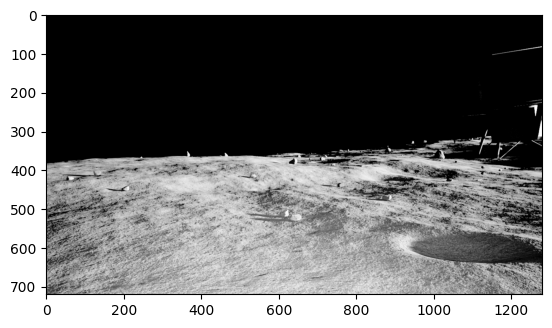

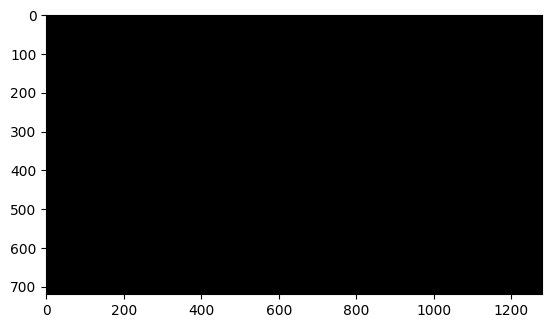

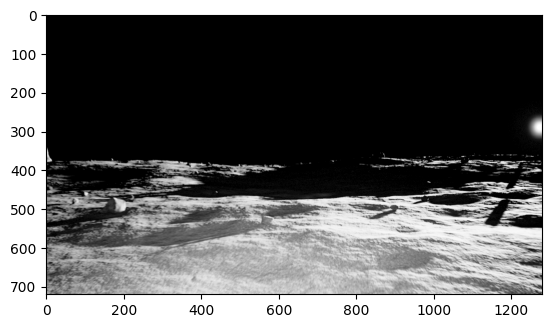

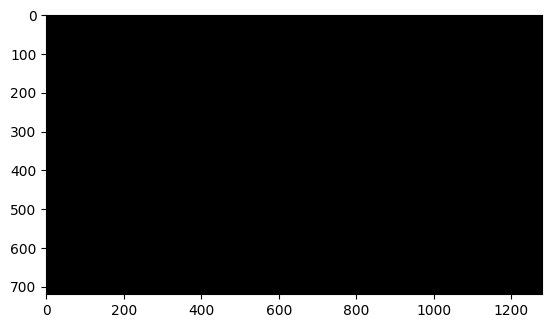

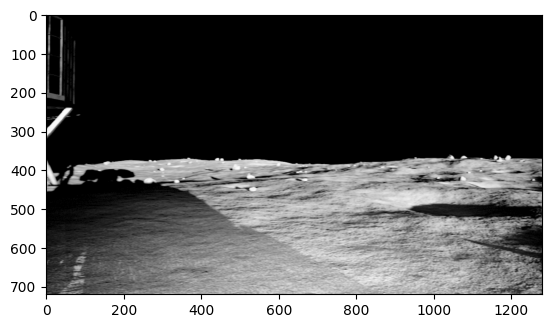

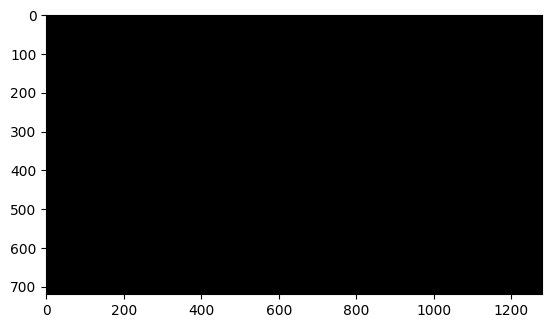

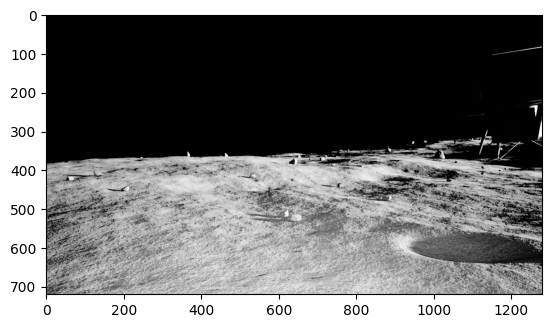

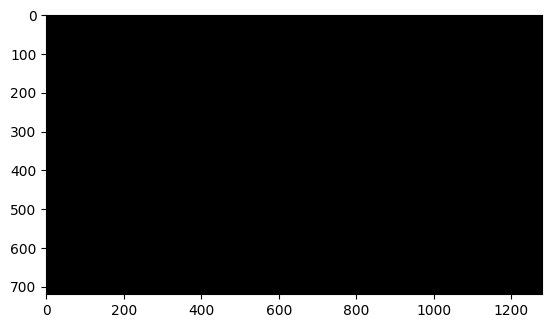

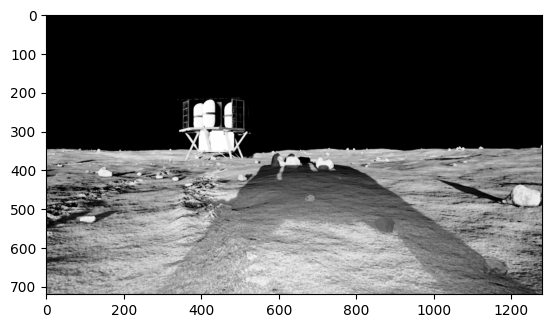

Predicting 1 masks
Predicted 1 masks
0.6270382


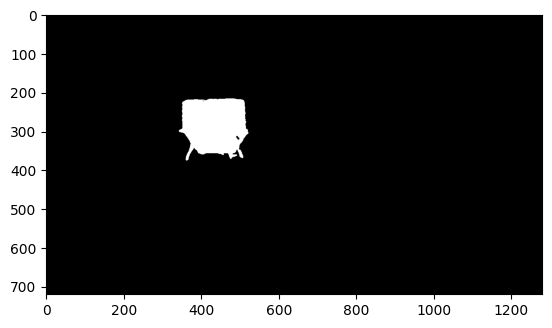

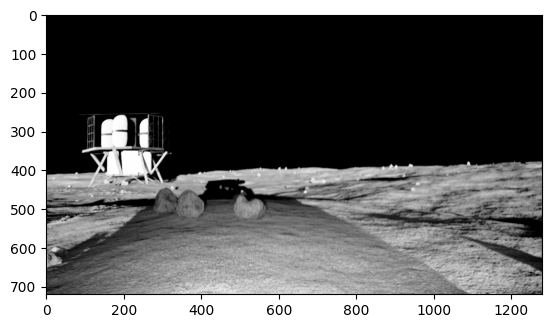

Predicting 1 masks
Predicted 1 masks
0.63793355


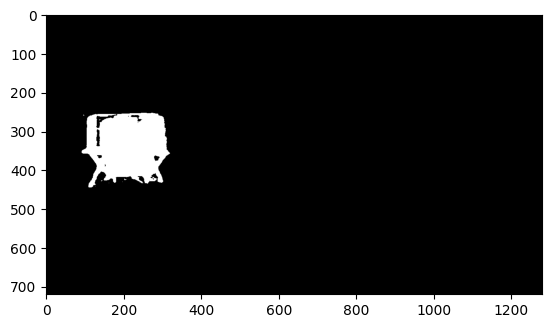

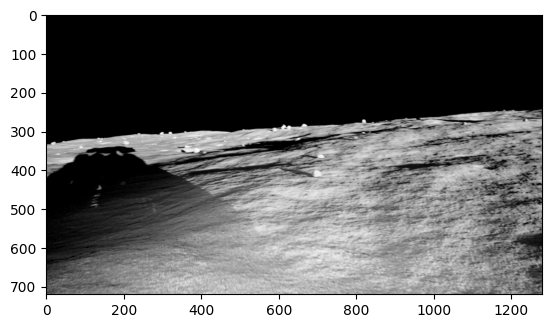

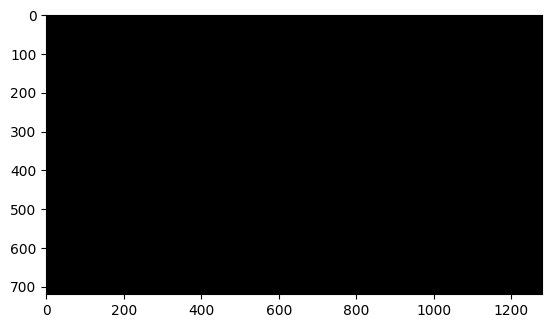

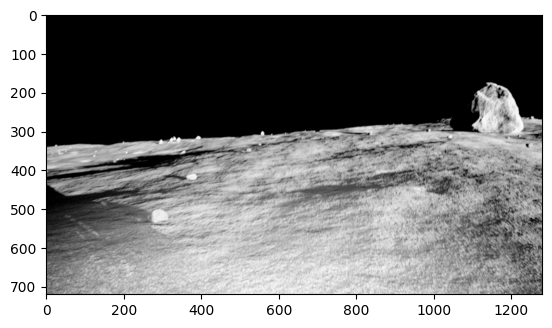

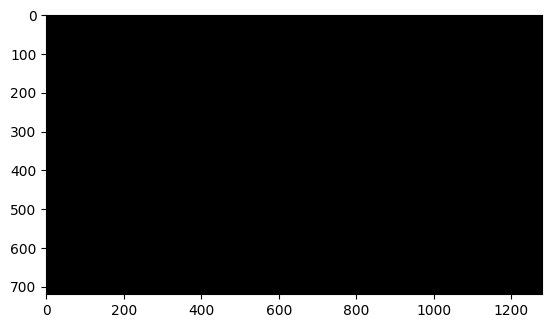

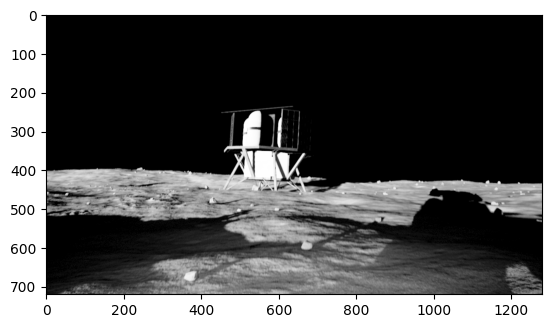

Predicting 1 masks
Predicted 1 masks
0.71701187


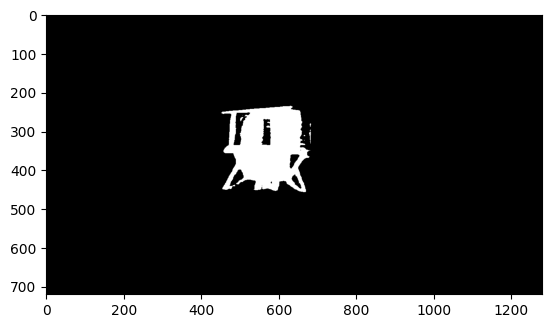

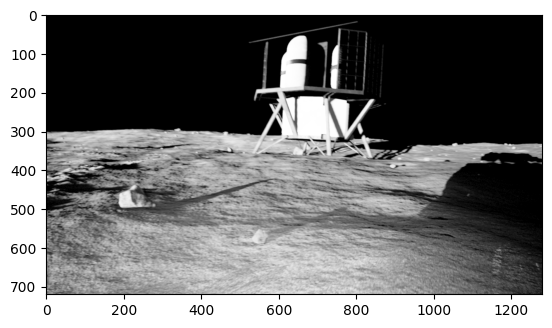

Predicting 1 masks
Predicted 1 masks
0.56457865


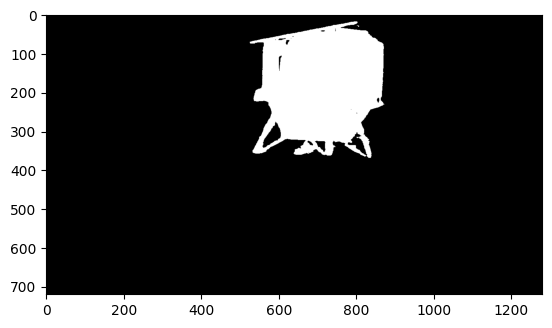

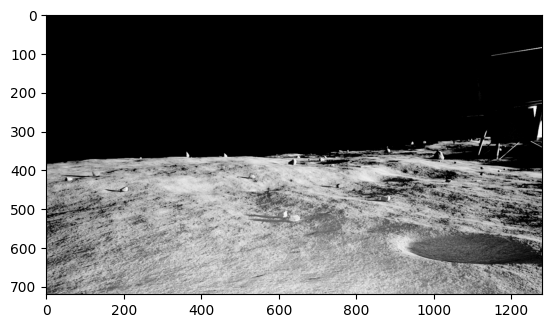

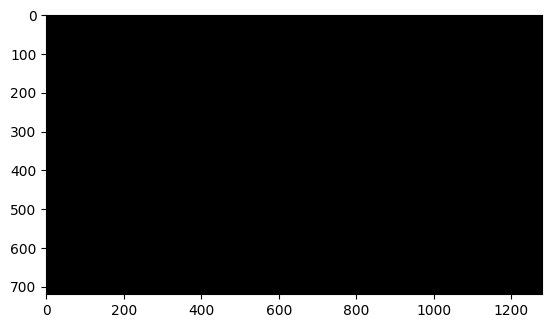

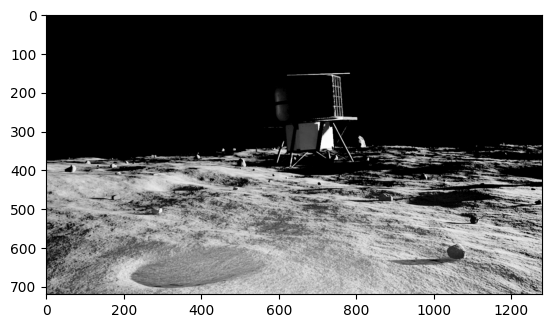

Predicting 1 masks
Predicted 1 masks
0.6288634


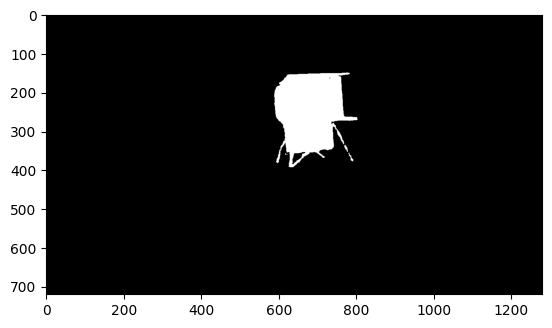

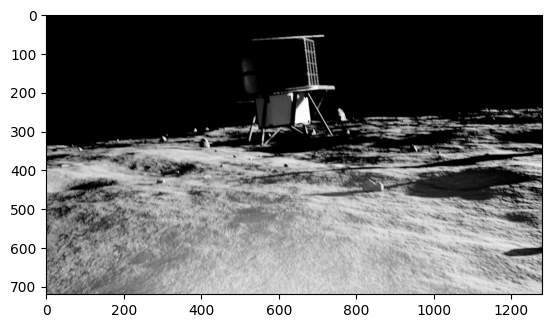

Predicting 1 masks
Predicted 1 masks
0.6334103


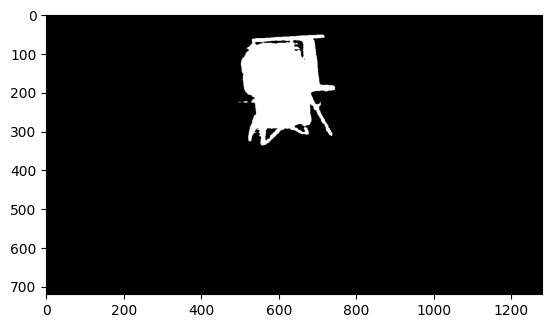

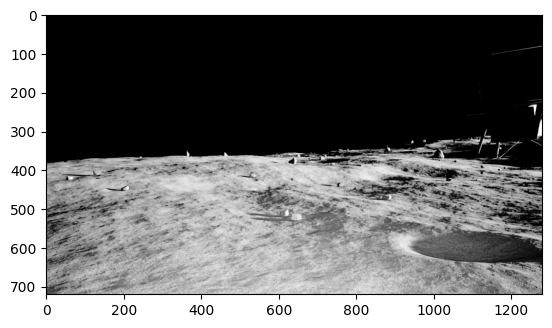

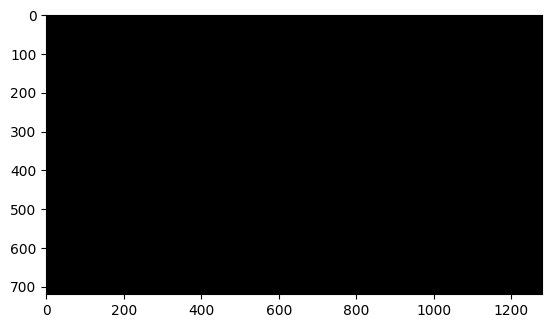

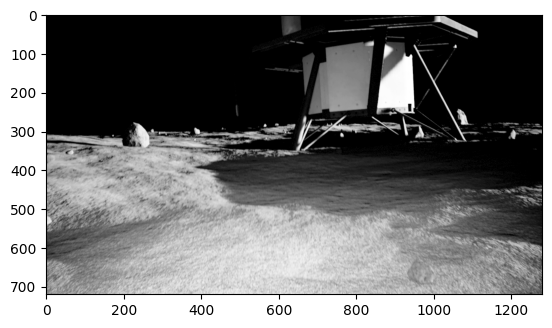

Predicting 1 masks
Predicted 1 masks
0.46830428


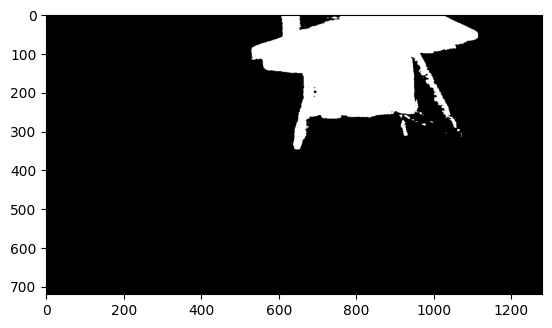

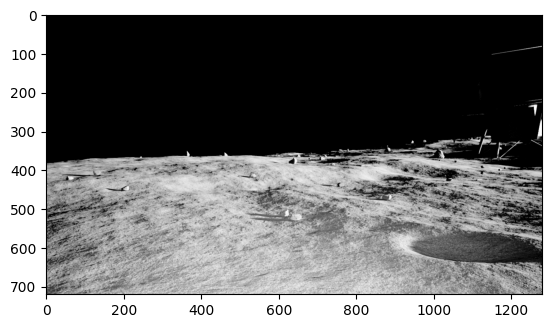

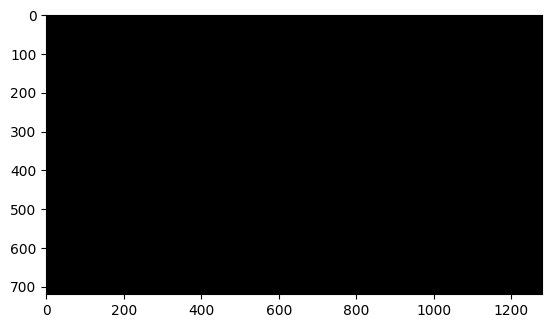

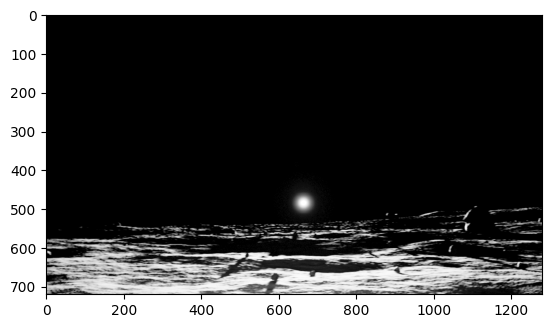

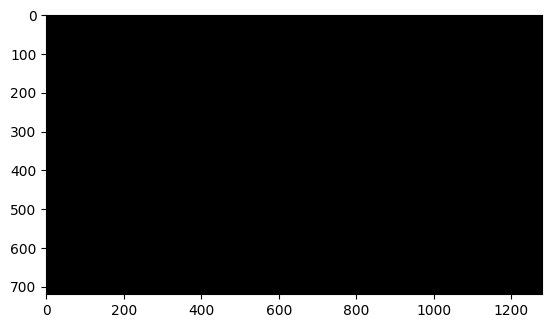

In [88]:
data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/lander_no_fiducials_front/")
imgs = os.listdir(os.path.join(data_path, "FrontLeft"))
imgs = [os.path.join(data_path, "FrontLeft", imgs[i]) for i in range(0, len(imgs), 100)]
imgs.sort()

# Segment lander
model = LangSAM()
text_prompt = "lander."
SEG_SCORE_THRESH = 0.4 # requires more testing
 
# for ind in i:
for img in imgs:
    I1 = cv.imread(os.path.join(data_path, "FrontLeft", img), cv.IMREAD_GRAYSCALE)
    plt.imshow(I1, cmap="gray")
    plt.show()

    image_seg_in = Image.open(os.path.join(data_path, "FrontLeft", img)).convert("RGB")
    results = model.predict([image_seg_in], [text_prompt])
    full_mask = np.zeros_like(image_seg_in).copy()
    if len(results) == 0:
        print("No masks found")
    for i, mask in enumerate(results[0]["masks"]):
        print(results[0]["scores"][i])
        if results[0]["scores"][i] < SEG_SCORE_THRESH: 
            continue
        full_mask[mask.astype(bool)] = 255

    plt.imshow(full_mask, cmap="gray")
    plt.show()


In [89]:
# extract ground truth data trajectory
json_data = json.load(open(f"{data_path}/data_log.json"))
initial_pose = np.array(json_data["initial_pose"])

data_log_path = os.path.join(data_path, "data_log.json")
data_log = json.load(open(data_log_path))

lander_pose_world = np.array(data_log["lander_pose_world"])

rover_traj_keys = ["timestamp", "pose"]
frame_data = data_log["frames"]
rover_traj_data = {key: [] for key in rover_traj_keys} 
for frame in frame_data:
    rover_traj_data["timestamp"].append(frame["timestamp"])
    rover_traj_data["pose"].append(frame["pose"])
rover_traj_data["pose"] = np.array(rover_traj_data["pose"])

# # visualize data
# plt.figure(figsize=(10, 10))
# plt.plot(lander_pose_world[0, 3], lander_pose_world[1, 3], "ro", label="lander")
# plt.plot(rover_traj_data["pose"][:, 0, 3], rover_traj_data["pose"][:, 1, 3], "b-", label="rover")
# plt.show()

# Using fiducials


In [90]:
data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/lander_closeups/")
#----- lander closeups -----------------------------------------------
# true examples
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/31.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/65.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/97.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/147.png
# /home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/181.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/265.png
# /home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/353.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/369.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/411.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/457.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/493.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/545.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/1199.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/1269.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/1665.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/1705.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/1751.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/2043.png

# difficult examples
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/799.png
# /home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/867.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/1111.png

# false examples
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/617.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/709.png
#/home/lac/LunarAutonomyChallenge/output/lander_closeups/FrontLeft/763.png

i = [31, 65, 97, 147, 181, 265, 353, 369, 411, 457, 493, 545, 1199, 1269, 1665, 1705, 1751, 2043, 799, 867, 1111, 617, 709, 763]

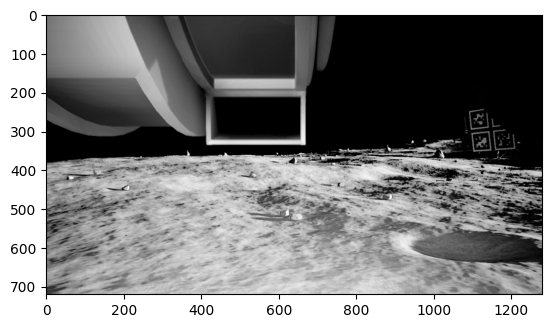

Predicting 1 masks
Predicted 1 masks
0.48303878
0.37022537
0.47158825
0.46915543
0.3738758


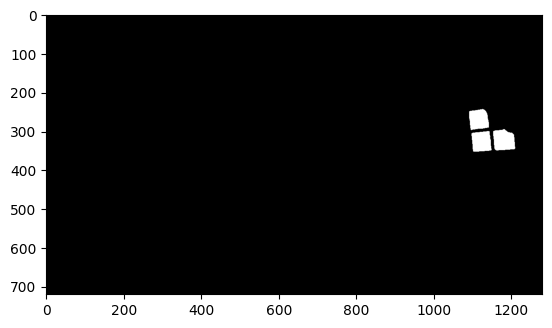

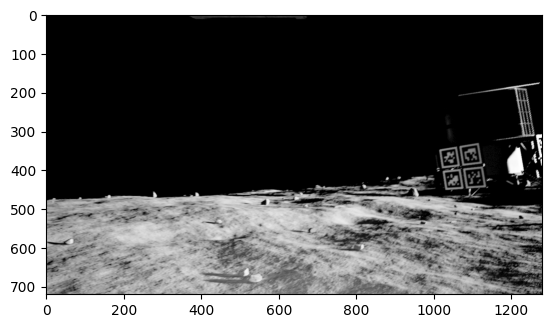

Predicting 1 masks
Predicted 1 masks
0.53679854
0.54939884
0.5636182
0.55109054


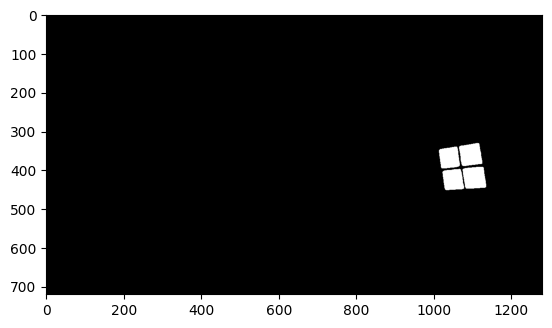

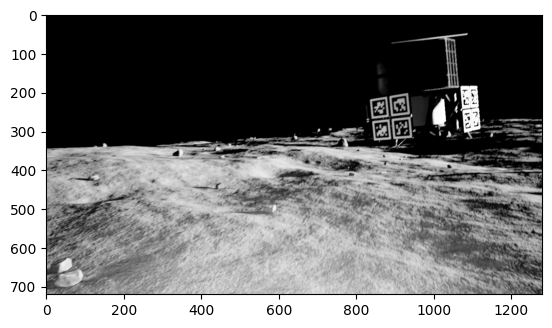

Predicting 1 masks
Predicted 1 masks
0.52755994
0.52305496
0.51866806
0.515437
0.42871165
0.39513415
0.39373463
0.33372033
0.36477757
0.42584395


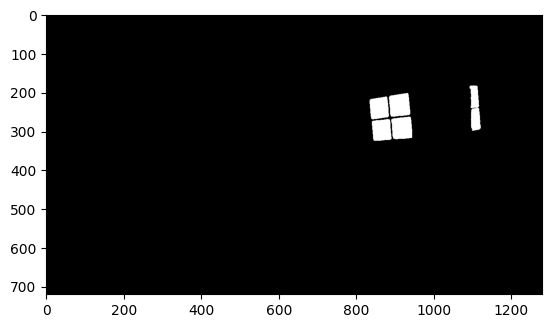

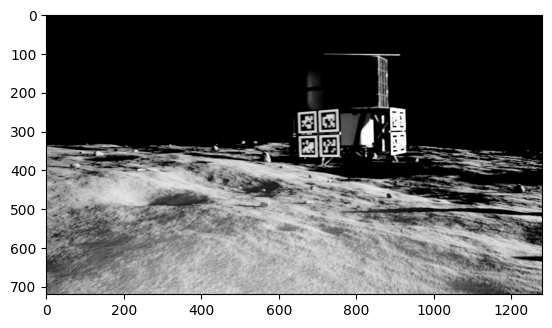

Predicting 1 masks
Predicted 1 masks
0.55953074
0.57128835
0.5549529
0.53679854
0.40544873
0.34953272


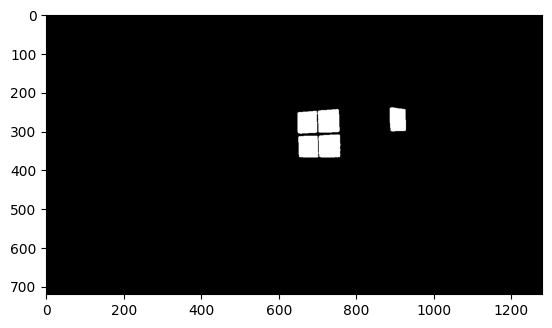

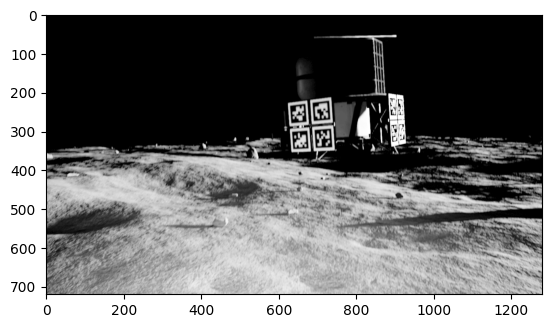

Predicting 1 masks
Predicted 1 masks
0.532182
0.53801244
0.53679854
0.5612148
0.35756752
0.4007494
0.31320965
0.33198547
0.3711366
0.36206648


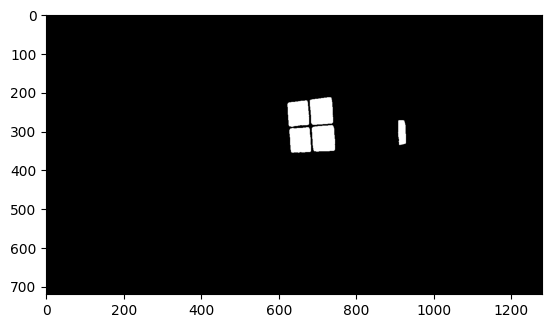

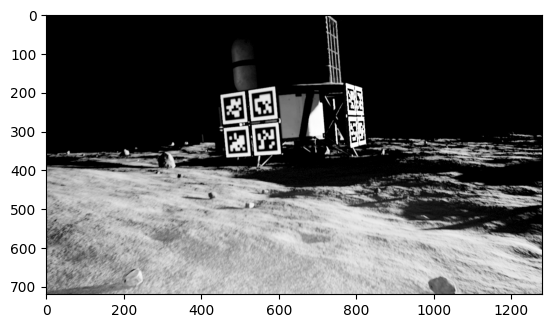

Predicting 1 masks
Predicted 1 masks
0.5822535
0.5774954
0.56985265
0.5636182
0.41063806
0.3693151
0.41822165
0.38954657


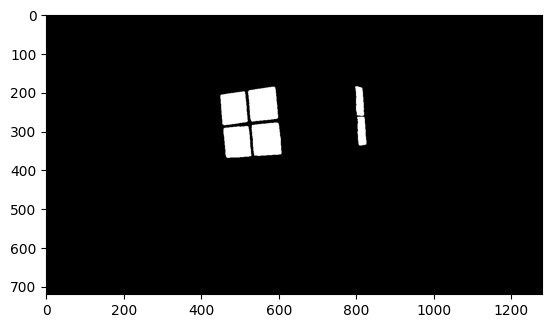

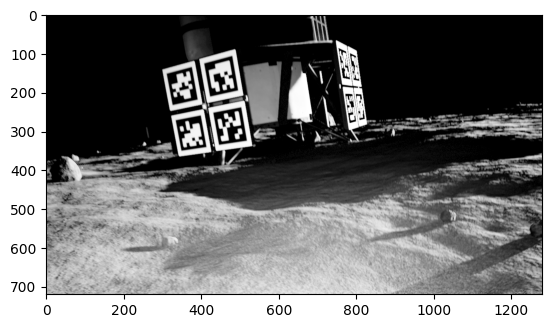

Predicting 1 masks
Predicted 1 masks
0.59690315
0.590307
0.59313804
0.597373
0.36749724
0.33895186
0.36568317
0.33807713
0.3720488
0.37662312


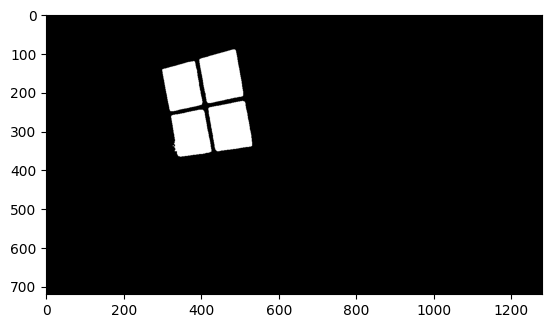

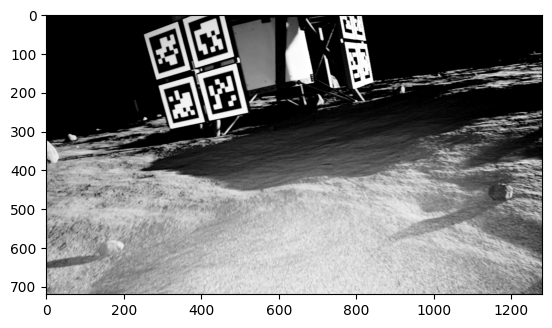

Predicting 1 masks
Predicted 1 masks
0.5688949
0.53704137
0.57654196
0.55615854
0.3242354
0.3242354


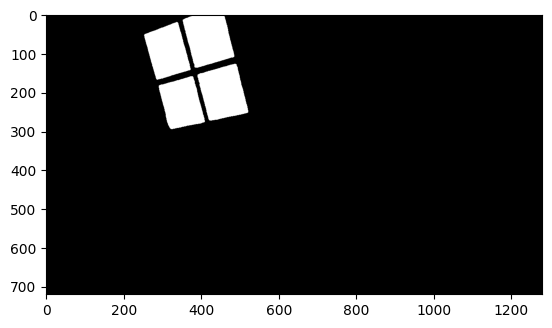

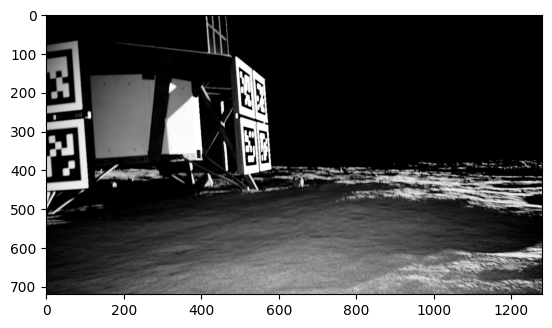

Predicting 1 masks
Predicted 1 masks
0.43062615
0.45374593
0.42202815
0.42775524
0.4390257
0.42775524
0.35846534
0.35846534


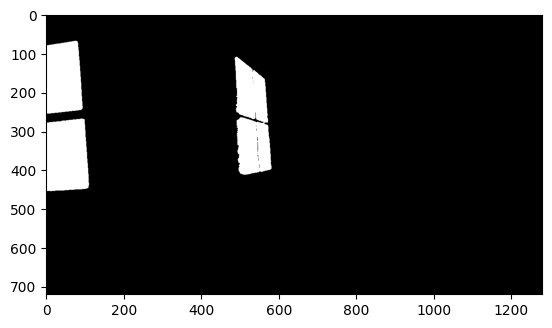

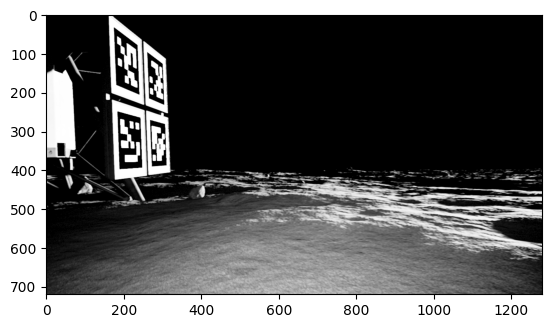

Predicting 1 masks
Predicted 1 masks
0.5197651
0.51939946
0.52147114
0.50445545


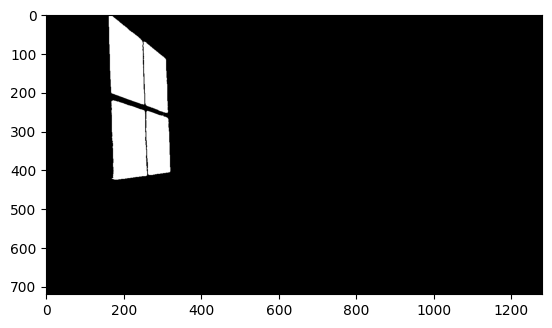

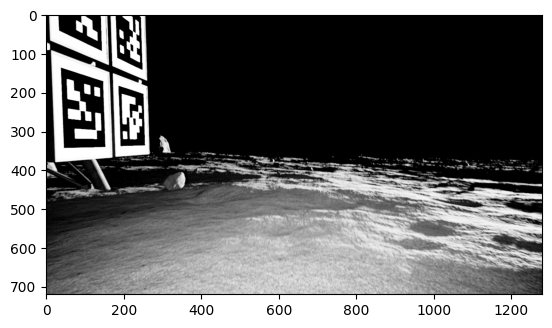

Predicting 1 masks
Predicted 1 masks
0.50848305
0.5133635
0.5355843
0.5301149


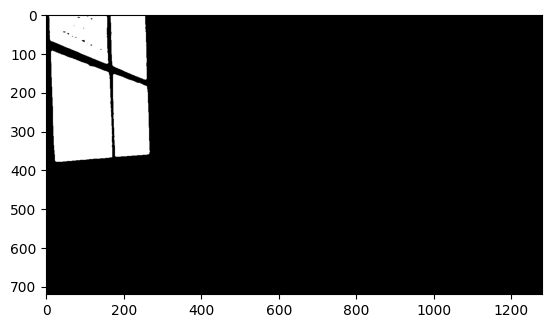

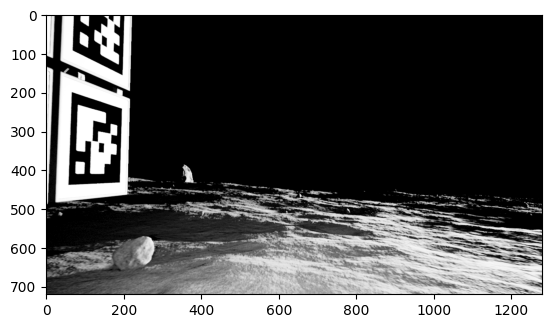

Predicting 1 masks
Predicted 1 masks
0.53607005
0.47901624


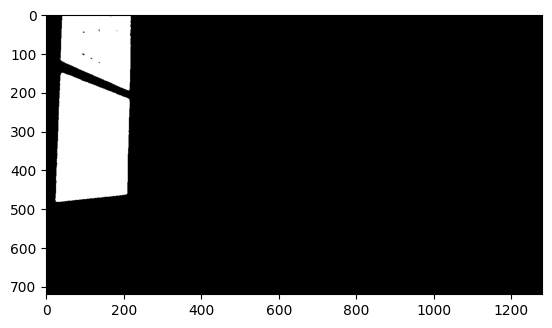

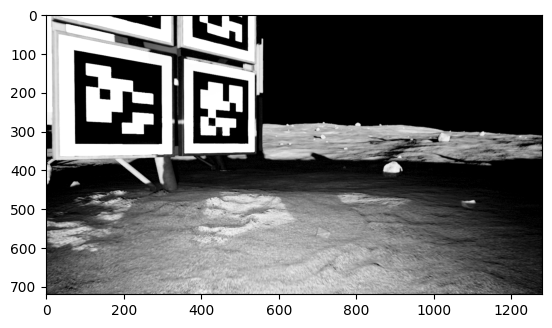

Predicting 1 masks
Predicted 1 masks
0.60346454
0.57892436
0.56169575
0.52768165


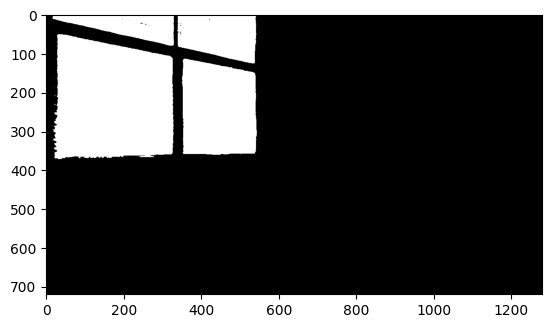

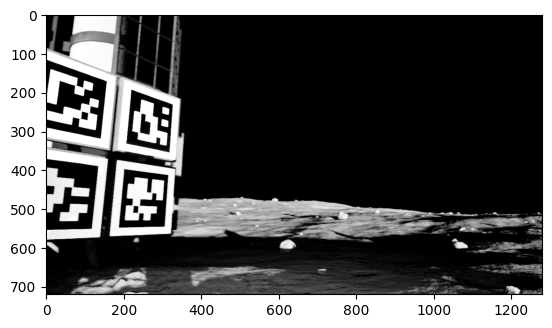

Predicting 1 masks
Predicted 1 masks
0.5851011
0.53849787
0.54140884
0.5288984


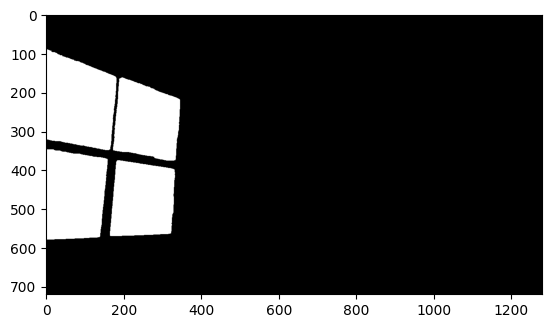

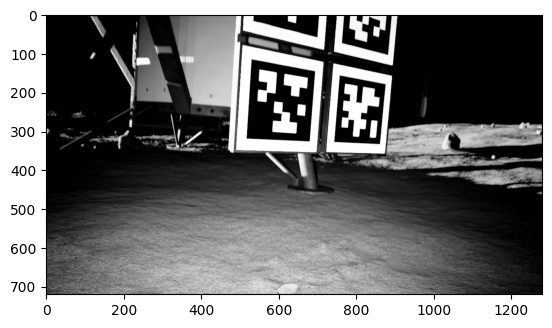

Predicting 1 masks
Predicted 1 masks
0.59643316
0.5855752
0.55302256
0.54237854


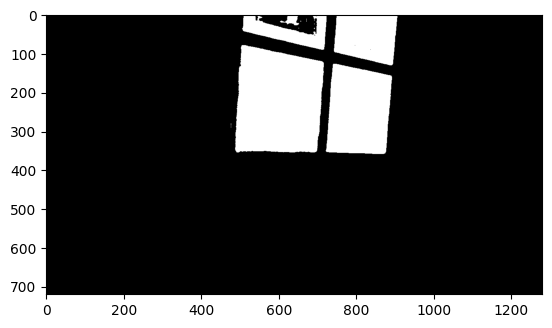

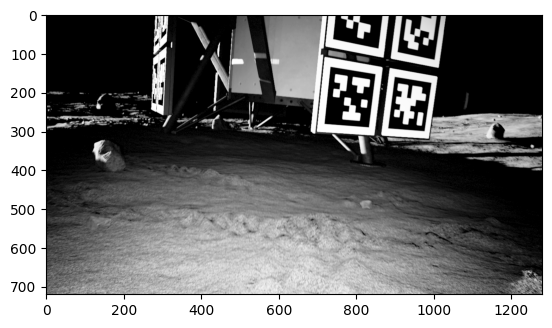

Predicting 1 masks
Predicted 1 masks
0.58604914
0.5879431
0.5484317
0.5520568


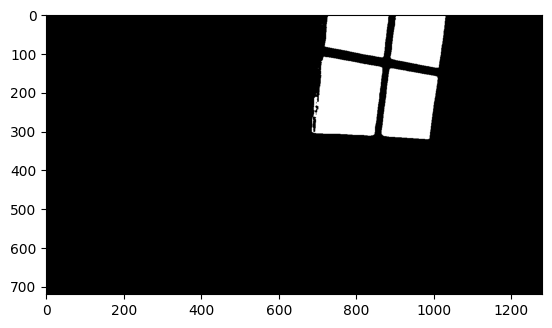

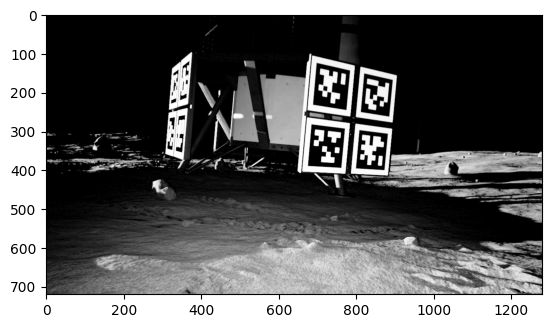

Predicting 1 masks
Predicted 1 masks
0.58082765
0.56025267
0.57701874
0.5817784
0.3711366
0.3106944
0.38352585
0.3424616
0.344223


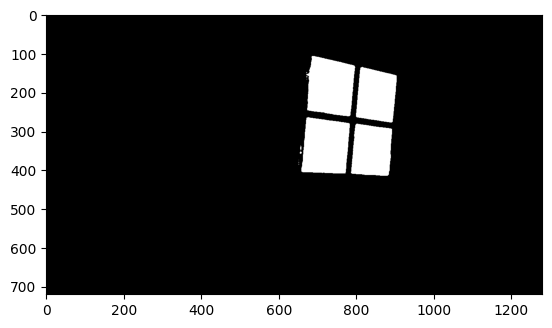

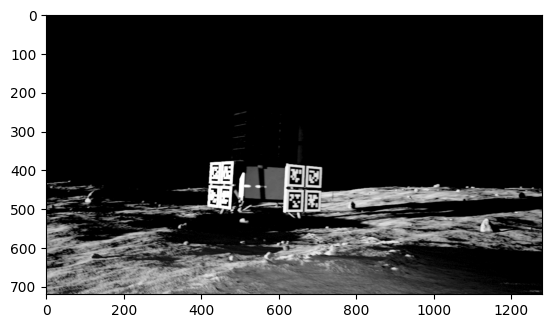

Predicting 1 masks
Predicted 1 masks
0.55229825
0.5609743
0.55229825
0.54237854
0.5065304
0.48084432
0.4696419
0.48291677
0.30652705
0.3106944


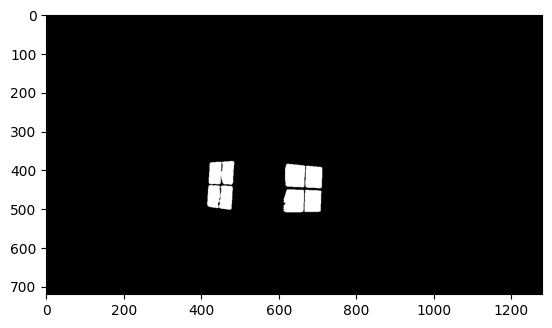

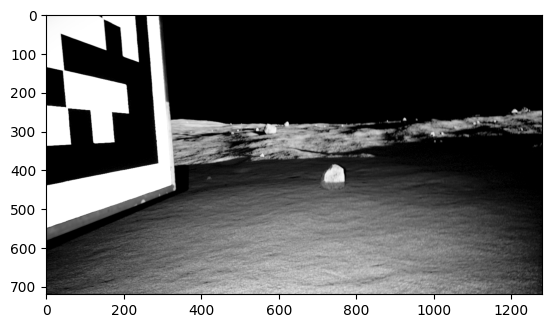

Predicting 1 masks
Predicted 1 masks
0.4380639
0.3208213


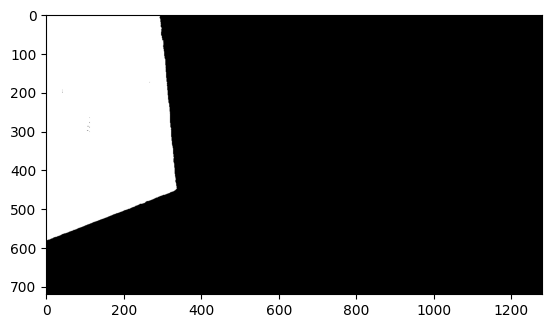

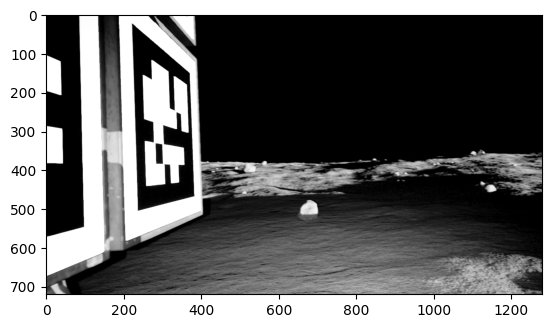

Predicting 1 masks
Predicted 1 masks
0.48255107
0.31573597


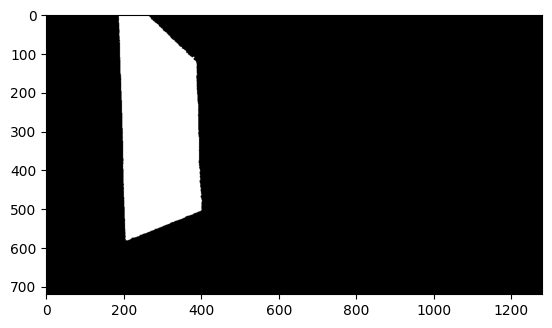

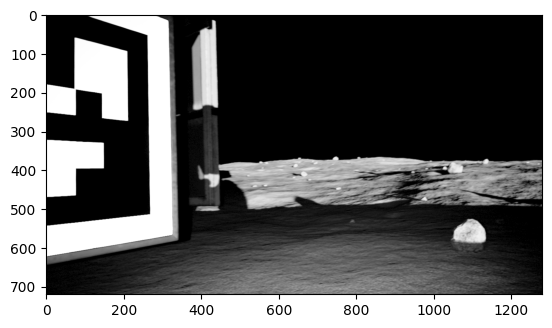

Predicting 1 masks
Predicted 1 masks
0.51080155


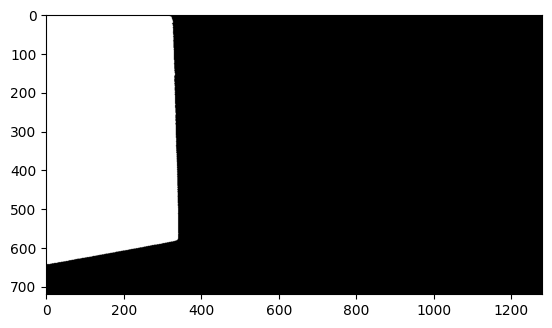

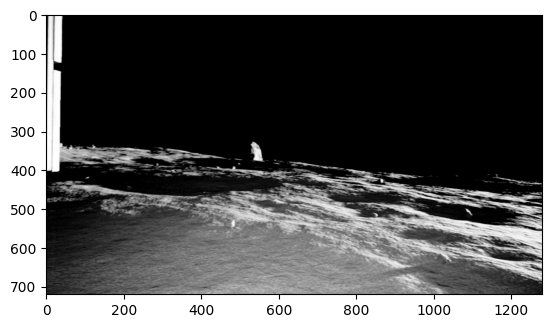

Predicting 1 masks
Predicted 1 masks
0.3242354


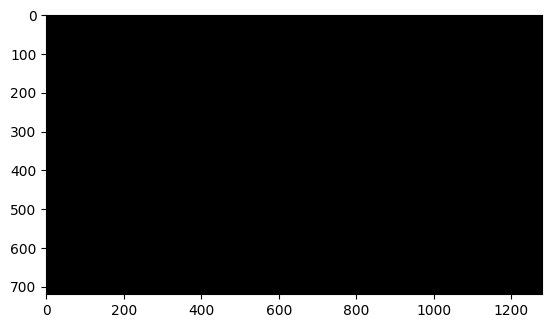

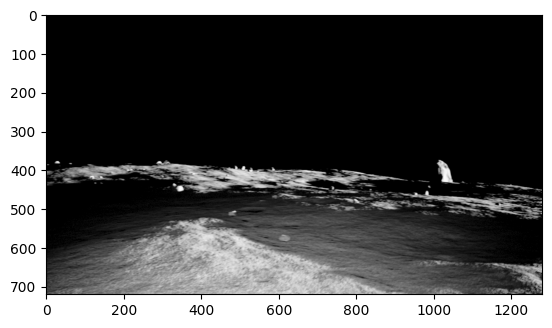

Predicting 1 masks
Predicted 1 masks
0.3276683


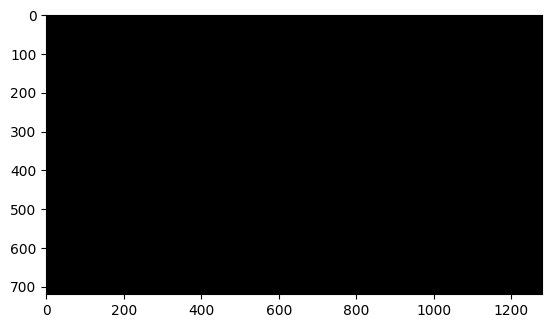

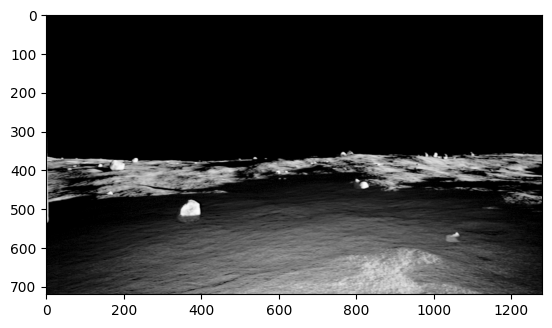

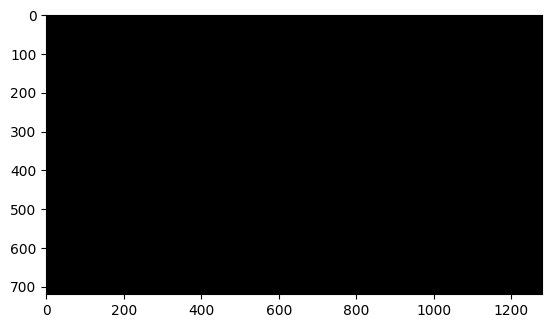

In [91]:
# Segment fiducials
model = LangSAM()
text_prompt = "square."
SEG_SCORE_THRESH = 0.4 # requires more testing
 
# for ind in i:
for ind in i:
    I1 = cv.imread(os.path.join(data_path, "FrontLeft", f"{ind}.png"), cv.IMREAD_GRAYSCALE)
    plt.imshow(I1, cmap="gray")
    plt.show()

    image_seg_in = Image.open(os.path.join(data_path, "FrontLeft", f"{ind}.png")).convert("RGB")
    results = model.predict([image_seg_in], [text_prompt])
    full_mask = np.zeros_like(image_seg_in).copy()
    for i, mask in enumerate(results[0]["masks"]):
        print(results[0]["scores"][i])
        if results[0]["scores"][i] < SEG_SCORE_THRESH: 
            continue
        full_mask[mask.astype(bool)] = 255

    plt.imshow(full_mask, cmap="gray")
    plt.show()

In [92]:
# known fiducial corner positions
fiducial_group_centers = json.load(open(os.path.expanduser("~/LunarAutonomyChallenge/docs/geometry.json")))["lander"]["fiducials"]
centers_group_a = fiducial_group_centers["a"]
centers_group_b = fiducial_group_centers["b"]
centers_group_c = fiducial_group_centers["c"]
centers_group_d = fiducial_group_centers["d"] 

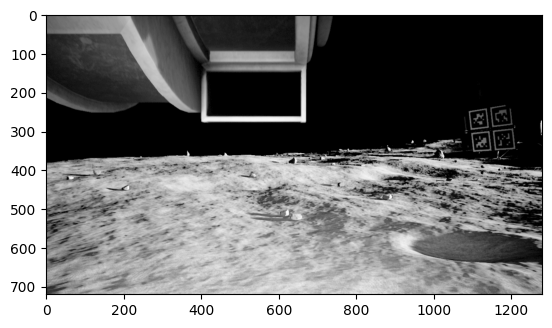

In [93]:
# use frame 35 as the initial frame -- first-ish frame with apriltags visible
init_frame = 35
# rover_init_pose  = rover_traj_data["pose"][0, :, :]
rover_init_pose = rover_traj_data["pose"][init_frame, :, :]
I1 = cv.imread(os.path.join(data_path, "FrontLeft", f"{init_frame}.png"), cv.IMREAD_GRAYSCALE)
plt.imshow(I1, cmap="gray")
plt.show()

Predicting 1 masks
Predicted 1 masks
0.42966866
0.49176097
0.5098864
0.49725345
0.48566067


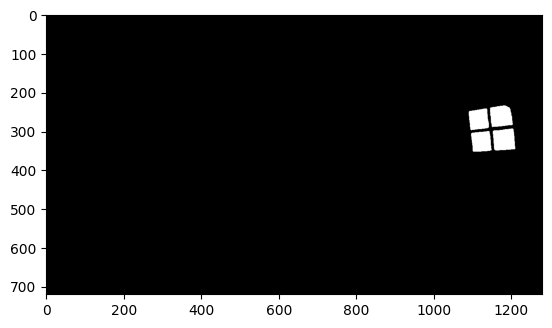

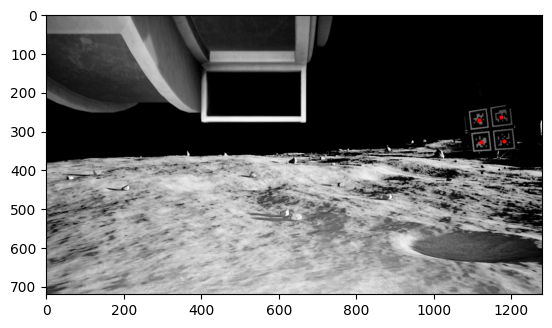

In [94]:
# extract the fiducial shapes from the initial frame
text_prompt = "square."
image_seg_in = Image.open(os.path.join(data_path, "FrontLeft", f"{init_frame}.png")).convert("RGB")
results = model.predict([image_seg_in], [text_prompt])
full_mask = np.zeros_like(image_seg_in).copy()
for i, mask in enumerate(results[0]["masks"]):
    print(results[0]["scores"][i])
    if results[0]["scores"][i] < 0.45:
        # TODO: the score threshold will require tuning 
        continue
    full_mask[mask.astype(bool)] = 255

plt.imshow(full_mask, cmap="gray")
plt.show()

# extract the center of each mask
mask_centers = []
for i, mask in enumerate(results[0]["masks"]):
    if results[0]["scores"][i] < 0.45:
        continue
    mask = mask.astype(bool)
    mask_center = np.mean(np.argwhere(mask), axis=0)
    mask_centers.append(mask_center)

# plot on image
plt.imshow(I1, cmap="gray")
for center in mask_centers:
    plt.plot(center[1], center[0], "ro", markersize=2)
plt.show()

In [95]:
# sort mask centers by y-coordinate
mask_centers = np.array(mask_centers)
mask_centers = mask_centers[np.argsort(mask_centers[:, 0])]

# sort into top left top right bottom left bottom right
top_centers = mask_centers[:2]
bottom_centers = mask_centers[2:]
top_centers = top_centers[np.argsort(top_centers[:, 1])]
bottom_centers = bottom_centers[np.argsort(bottom_centers[:, 1])]
bottom_centers = bottom_centers[::-1]
mask_centers = np.vstack([top_centers, bottom_centers])

# reverse the column order to match the fiducial group centers
mask_centers = mask_centers[:, ::-1]

In [ ]:
# solve PnP
# TODO: get which fidicucial group is in the photo via rover pose estimate
TAG_KEYS = ["top left", "top right", "lower right", "lower left"]
world_pts = np.array([[centers_group_d[key]["x"], centers_group_d[key]["y"], centers_group_d[key]["z"]] for key in TAG_KEYS])
image_pts = mask_centers

pnp_success, rvec, tvec = cv.solvePnP(world_pts, mask_centers, K, None)
if pnp_success:
    # extract rotation and translation
    rmat, _ = cv.Rodrigues(rvec)

In [97]:
from scipy.spatial.transform import Rotation as R
R.from_matrix(rover_init_pose[:3, :3]).as_euler("zyx", degrees=True)

array([14.78433751,  2.34701269,  4.60921979])

In [98]:
R.from_matrix(rmat).as_euler("zyx", degrees=True)   

array([-44.88712354,  -4.55172398,  90.94132426])

In [99]:
mask_centers

array([[1116.44439851,  270.55560149],
       [1173.75465498,  262.72325666],
       [1181.68633649,  322.84229013],
       [1123.08862325,  327.62283594]])